# Watershed-based oversampling for imbalanceddataset classification: WSSMOTE

For several real-world problems, the dataset is composed of two or more imbalanced classes: a minority and majority ones. With usual machine learning methods, this imbalance often leads to poor results where the majority class is over-fitted while the minority class is misclassified. To alleviate these issues, several pre-processing methods, such as SMOTE andDBSMOTE, create new artificial points for the minority class. Nevertheless, these oversampling methods explicitly or implicitly make hypothesesabout the clusters size, shape, or density that may not fit the datasetin  practice.  We  propose  to  improve  these  oversampling methods and reduce cluster assumptions, by relying a classifier:  the  watershed-cut.  We  called  this  method  WSSMOTE.

-------------------------------------------------------------------------------------------------------------------------------
Following code generates chessboard plots with several oversampling methods. 

In [1]:
# pip install higra

In [2]:
# pip install smote-variants

In [3]:
import numpy as np
import pandas as pd
import higra as hg
import scipy as sp
import matplotlib.pyplot as plt

import random
import imblearn

from pylab import *

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from smote_variants import DBSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

## Compute ChessBoard data points

In [4]:
def return_chessboard(div=5, N=100, per=0.2):
    lim = [0]
    X = []
    Y = []
    for i in range(1, div):
        lim.append(i/float(div))
    lim.append(1)
    
    nb_min = 0
    
    while len(X) < N:
        x = [np.random.uniform(0,1), np.random.uniform(0,1)]
        
        ind_x = 0
        while x[0]> lim[ind_x]:
            ind_x +=1
            
        ind_y = 0
        while x[1] >lim[ind_y]:
            ind_y += 1
            
        if ind_x%2 == 1:
            if ind_y%2 == 1:
                X.append(x)
                Y.append(1)
            else:
                if nb_min < N*per:
                    X.append(x)
                    Y.append(2)
                    nb_min +=1
        else:
            if ind_y%2 == 1:
                if nb_min <N*per:
                    X.append(x)
                    Y.append(2)
                    nb_min +=1
            else:
                X.append(x)
                Y.append(1)

    return np.array(X), np.array(Y)

## WSSMOTE algorithm

In [5]:
def dijkstra(graph, source):
    '''
    Dijkstra algorithm:
    Input: 
        - Graph: array containing dictionnary 
        - Source: Vertex
    Output: 
        - Distances: dictionnary
        - Parents: dictionnary
    '''
    distances, parents = dict(), dict()

    for node in graph:
        distances[node] = float('Inf')
        parents[node] = None
    distances[source] = 0

    for ind_graph in range(len(graph)-1):
        for pt_i in graph:
            for pt_j in graph[pt_i]:
                assert graph[pt_i][pt_j] >= 0
                if distances[pt_j] > distances[pt_i] + graph[pt_i][pt_j]:
                    distances[pt_j] = distances[pt_i] + graph[pt_i][pt_j]
                    parents[pt_j] = pt_i

    return distances, parents

In [ ]:
def higra_clustering(X_min, n_nei):
    '''
    Generate clusters using Higra
    Input:
        - X_min: minority dataset 
        - n_nei: Number of neighbors 
    Output:
        - labels: clustering labelling
        - num_labels: numbers of clusters
    '''
    graph, edge_weights = hg.make_graph_from_points(X_min, graph_type='knn', mode='distance', n_neighbors=n_nei)
    labels = hg.labelisation_watershed(graph, edge_weights)
    num_labels = np.max(labels)
    return labels - 1, num_labels

In [41]:
def WSSMOTE(X, labels, n_nei, coeff_min, n_add):
    '''
    WSSMOTE algorithm
    Input:
        - X: data points
        - labels: array
        - n_nei: number of neighbors
        - coeff_min: label of the minority class
    Output:
        - np.vstack([X, samples]): oversampling data 
        - np.hstack([labels, np.repeat(coeff_min, len(samples))]): oversampling labels
    '''
     #Compute clusters
    X_min = X[labels == coeff_min]
    labels_clust, num_labels = higra_clustering(X_min, n_nei)

    #Construct array of clusters
    clusters = [np.where(labels_clust == ind_label)[0] for ind_label in range(num_labels)]
    cluster_sizes = np.array([np.sum(labels_clust == i) for i in range(num_labels)])
    cluster_dist = cluster_sizes/(np.sum(cluster_sizes))

    #Graphs, shortest path and centroids
    graphs, centroid_indices, sorthest_path = [], [], []
    
    for num_label in range(num_labels):
        cluster = X_min[clusters[num_label]]
        graph = dict() # key: cluster indice, value: 
        nn = NearestNeighbors(n_neighbors=len(cluster), metric='euclidean', n_jobs=1).fit(cluster)
        dist, ind = nn.kneighbors(cluster)
        for pt_cluster_i in range(len(cluster)):
            graph[pt_cluster_i] = dict()
            for pt_cluster_j in range(len(cluster)):
                graph[pt_cluster_i][pt_cluster_j] = dist[pt_cluster_i][ind[pt_cluster_i] == pt_cluster_j][0]
        centroid_ind = nn.kneighbors(np.mean(cluster, axis=0).reshape(1, -1))[1][0][0]
        centroid_indices.append(centroid_ind)
        sorthest_path.append(dijkstra(graph, centroid_ind))
        graphs.append(graph)
    #New data points creation
    samples = []
    while len(samples) < n_add*abs(len(np.where(labels==coeff_min)[0]) - len(np.where(labels==((1+coeff_min)%2))[0])):
        cluster_idx = np.random.choice(np.arange(len(clusters)), p=cluster_dist)
        cluster = X_min[clusters[cluster_idx]]
        idx = np.random.choice(range(len(clusters[cluster_idx])))

        distances, parents = sorthest_path[cluster_idx]

        path = [idx]
        while not parents[path[-1]] is None:
            path.append(parents[path[-1]])

        if len(path) == 1:
            X_b = cluster[path[0]]
            samples.append(X_b)
        else:
            random_vertex = np.random.randint(len(path)-1)
            X_a = cluster[path[random_vertex]]
            X_b = cluster[path[random_vertex+1]]
            sample = X_a + (X_b-X_a)*np.random.uniform(0,1)
            samples.append(sample)
    return np.vstack([X, samples]), np.hstack([labels, np.repeat(coeff_min, len(samples))])

## Plot ChessBoard with several oversampling methods

In [42]:
def plot__X_y(X, Y, name_graph):
    """
    Function: 
        - Plot 2D data
        - Colors: 
            - Dark: Majority data points using for the training part
            - Yellow: Minority data points using for the training part
            - Orange: Minority data points added by oversampling method
    """

    f = plt.figure()
    nb_different_labels = np.unique(Y)

    plot_colors = ['#000000','#ff0000', '#7bc8f6'] #black, red, green
    pot_form = ['^', 'o', 'x']
    
    for i, color, mark in zip([1, 2, 3], plot_colors, pot_form):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, marker= mark)

    plt.grid(b= True, color='black')
#     plt.title(name_graph)
    plt.show()
    f.savefig(".\{}_2.pdf".format(name_graph))

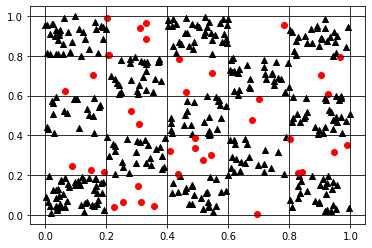

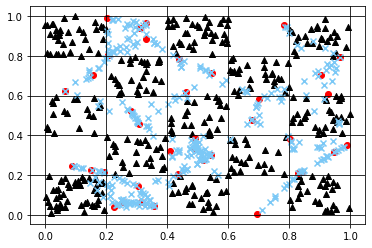

2021-06-14 09:47:39,825:INFO:DBSMOTE: Running sampling via ('DBSMOTE', "{'proportion': 1.0, 'eps': 0.8, 'min_samples': 3, 'n_jobs': 1, 'random_state': None}")
C:\Users\oucht\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


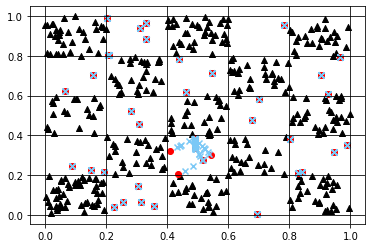

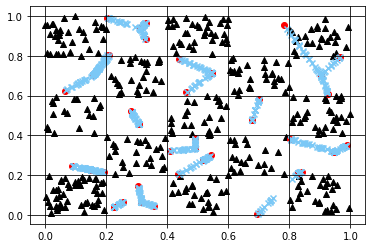

In [44]:
examples = [return_chessboard]
methods_over = ['without', 'SMOTE', 'DBSMOTE', 'WSSMOTE']

for idx, example in enumerate(examples): 
    X, y = example()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
  
    for over in methods_over:
        if over == 'without': 
            X_train_over, y_train_over_= X_train.copy(), y_train.copy()
            X_tot = np.concatenate((X_train, X_test))
            y_tot = np.concatenate((y_train, [0]*y_test))
        elif over == 'SMOTE':
            sm = SMOTE()
            X_train_over, y_train_over= sm.fit_resample(X_train, y_train)
            y_train_over_ = np.concatenate((y_train, [3]*(len(y_train_over)-len(y_train))))
            X_tot = np.concatenate((X_train_over, X_test))
            y_tot = np.concatenate((y_train_over_, [0]*y_test))
        elif over == 'DBSMOTE':
            sm = DBSMOTE(min_samples=3)
            X_train_over, y_train_over= sm.fit_resample(X_train, y_train)
            y_train_over_ = np.concatenate((y_train, [3]*(len(y_train_over)-len(y_train))))
            X_tot = np.concatenate((X_train_over, X_test))
            y_tot = np.concatenate((y_train_over_, [0]*y_test))
        else:
            X_train_over, y_train_over= WSSMOTE(X_train, y_train, n_nei=10, coeff_min=2)
            y_train_over_ = np.concatenate((y_train, [3]*(len(y_train_over)-len(y_train))))
            X_tot = np.concatenate((X_train_over, X_test))
            y_tot = np.concatenate((y_train_over_, [0]*y_test))
        plot__X_y(X_train_over, y_train_over_, "Chessboard preprocessing with {}".format(over))

## Plot Chessbord with clustering

In [45]:
def return_centroid_clusters(X_train, y_train):
    ss = StandardScaler().fit(X_train)
    X_ss = ss.transform(X_train)

    X_min = X_ss[y_train==2]

    graph, edge_weights = hg.make_graph_from_points(X_min, graph_type='knn', mode='distance', n_neighbors=1)
    labels = hg.labelisation_watershed(graph, edge_weights)

    y_cluster_min = hg.labelisation_watershed(graph, edge_weights)

    X_cluster = np.concatenate((X_train[np.where(y_train==1)[0]], X_train[np.where(y_train==2)[0]]))
    y_cluster = np.concatenate(([0]*len(X[np.where(y_train==1)[0]]), y_cluster_min+1))

    num_labels = len((np.unique(y_cluster_min)))
    clusters = [np.where(y_cluster_min == i)[0] for i in range(1,(num_labels+1))]
    cluster_sizes = np.array([np.sum(y_cluster_min == i) for i in range(1,(num_labels+1))])
    cluster_dist = cluster_sizes/(np.sum(cluster_sizes))
    centroids = []
    for c in range(0,num_labels):
        cluster =  X_train[np.where(y_train==2)[0]][clusters[c]]
        centroids.append([np.mean(cluster, axis=0)])
        
    return X_cluster, y_cluster, centroids

In [46]:
def plot_cluster(X_cluster, y_cluster, centroids):
    f = plt.figure()
    cmap = cm.get_cmap('BrBG', 15) 
    plot_colors = []
    plot_colors.append("#000000")
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        plot_colors.append(matplotlib.colors.rgb2hex(rgb))

    ind=0
    for i, color in zip(np.unique(y_cluster), plot_colors):
        idx = np.where(y_cluster == i)
        plt.scatter(X_cluster[idx, 0], X_cluster[idx, 1], c=color)
        if ind != 0:
          plt.scatter(centroids[ind-1][0][0], centroids[ind-1][0][1], c='red', marker="X")
        ind = ind+1

    f.savefig("./WatershedClustering.pdf", bbox_inches='tight')

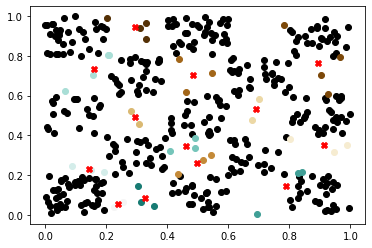

In [47]:
X_cluster, y_cluster, centroids =return_centroid_clusters(X_train, y_train)
plot_cluster(X_cluster, y_cluster, centroids)